<a href="https://colab.research.google.com/github/sabih411/CMPSC-448-Final-Project/blob/main/CMPSC448_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
import torch
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix
import keras
from keras import layers
from tensorflow.keras import layers, backend as K
import seaborn as sns

#Loading Data

In [ ]:
os.mkdir("Data")
os.chdir("Data")
!unzip /content/drive/MyDrive/emotionface/challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d /content/Data/

Archive:  /content/drive/MyDrive/emotionface/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: /content/Data/example_submission.csv  
  inflating: /content/Data/fer2013.tar.gz  
  inflating: /content/Data/icml_face_data.csv  
  inflating: /content/Data/test.csv  
  inflating: /content/Data/train.csv  


In [ ]:
image_array = []
label_array = []
label_dict={}

train_file=open("train.csv","r")
line1=train_file.readline()

for line in train_file:
  line=line.split(',')
  label,image_pixels=line[0],line[1]
  image_pixels=image_pixels.replace('"','')
  image_pixels=[int(value) for value in image_pixels.split(' ')]
  image_pixels = np.array(image_pixels, dtype='uint8')
  image = image_pixels.reshape((48, 48))

  image_array.append(image)
  label_array.append(int(line[0]))

  if int(label) in label_dict:
    label_dict[int(label)]+=1
  else:
    label_dict[int(label)]=1

x_train = np.array(image_array)
y_train = np.array(label_array)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


In [ ]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for i in range(7):
  print(LABELS[i], "has", label_dict[i], "samples")

Angry has 3995 samples
Disgust has 436 samples
Fear has 4097 samples
Happy has 7215 samples
Sad has 4830 samples
Surprise has 3171 samples
Neutral has 4965 samples


Visible Data imbalance  (Class **Disgust** just has 436 Samples)


## Normalization and Stratified Sampling

In [ ]:
x_train= x_train / 255.0  #Normalization

In [ ]:

n_splits = 1
test_size = 0.2
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

for train_index, test_index in sss.split(x_train, y_train):
    x_train_split, x_test = x_train[train_index], x_train[test_index]
    y_train_split, y_test = y_train[train_index], y_train[test_index]

sss_train = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=43)

for train_index, val_index in sss_train.split(x_train_split, y_train_split):
    x_train_final, x_val = x_train_split[train_index], x_train_split[val_index]
    y_train_final, y_val = y_train_split[train_index], y_train_split[val_index]

print("x_train_final shape:", x_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train_final shape: (18373, 48, 48)
y_train_final shape: (18373,)
x_val shape: (4594, 48, 48)
y_val shape: (4594,)
x_test shape: (5742, 48, 48)
y_test shape: (5742,)


## Data Visualization and Pre-processing

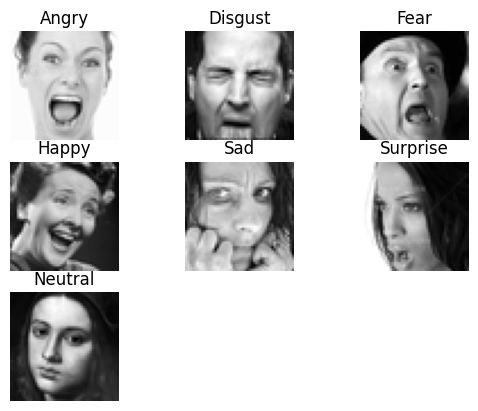

In [ ]:
plt.subplot(3,3,1)
plt.title("Angry")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==0)[0])],cmap="gray")

plt.subplot(3,3,2)
plt.title("Disgust")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==1)[0])],cmap="gray")

plt.subplot(3,3,3)
plt.title("Fear")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==2)[0])],cmap="gray")

plt.subplot(3,3,4)
plt.title("Happy")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==3)[0])],cmap="gray")

plt.subplot(3,3,5)
plt.title("Sad")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==4)[0])],cmap="gray")

plt.subplot(3,3,6)
plt.title("Surprise")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==5)[0])],cmap="gray")

plt.subplot(3,3,7)
plt.title("Neutral")
plt.axis("off")
plt.imshow(x_train[random.choice(np.where(y_train==6)[0])],cmap="gray")

Shown below is just an exmaple of the transformation visuals. While Training this was perfomed in real-time.

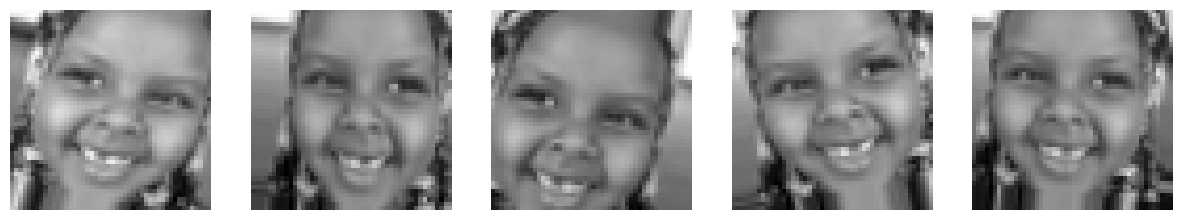

In [ ]:

data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
augmentation_examples = []
num_examples = 5
x=x_train[random.choice(np.where(y_train==3)[0])]
x = np.expand_dims(x, axis=0)
augmented_images = []
x=np.reshape(x,(48,48,1))

for i in range(5):
    augmented_img = data_generator.random_transform(x)

    augmented_images.append(augmented_img)

plt.figure(figsize=(15, 10))
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_img,cmap="gray")
    plt.axis('off')

plt.show()

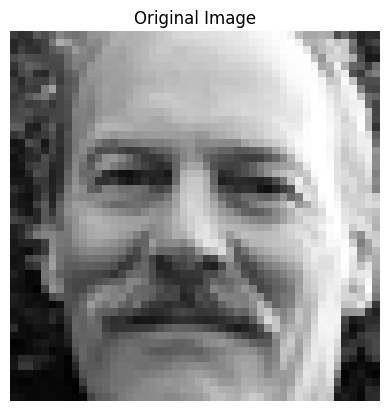

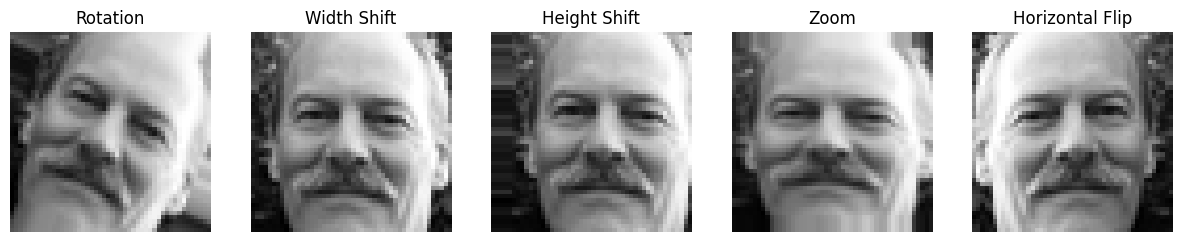

In [ ]:

x = x_train[np.random.choice(np.where(y_train == 3)[0])]
x = np.expand_dims(x, axis=0)
x = np.reshape(x, (48, 48, 1))

transformations = {
    "Rotation": ImageDataGenerator(rotation_range=30),
    "Width Shift": ImageDataGenerator(width_shift_range=0.1),
    "Height Shift": ImageDataGenerator(height_shift_range=0.2),
    "Zoom": ImageDataGenerator(zoom_range=0.2),
    "Horizontal Flip": ImageDataGenerator(horizontal_flip=True)
}
plt.imshow(x,cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

augmented_images = []
x=np.reshape(x,(1,48,48,1))
for transformation_name, datagen in transformations.items():
    it = datagen.flow(x, batch_size=1)
    augmented_image = it.next()
    augmented_images.append((transformation_name, augmented_image[0]))

plt.figure(figsize=(15, 10))
for i, (name, img) in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(name)
    plt.axis('off')

plt.show()

#Convolutional Neutral Network (CNN)

## Model Architecture

In [ ]:
model_conv = Sequential()
model_conv.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_conv.add(Dropout(0.3))
model_conv.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_conv.add(Dropout(0.3))
model_conv.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_conv.add(Dropout(0.3))
model_conv.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_conv.add(Dropout(0.3))
model_conv.add(Flatten())
model_conv.add(Dense(512, activation='relu'))
model_conv.add(Dropout(0.3))
model_conv.add(Dense(256, activation='relu'))
model_conv.add(Dropout(0.3))
model_conv.add(Dense(64, activation='relu'))
model_conv.add(Dropout(0.3))
model_conv.add(Dense(7, activation='softmax'))

In [ ]:
adam = Adam(learning_rate=0.001)
model_conv.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## Training Phase-I

In [ ]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/emotionweights/CNN/model_weights_epoch_{epoch:02d}.hdf5',
    save_weights_only=True,
    period=10)
history = model_conv.fit(x_train_final,
                        y_train_final,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate,model_checkpoint])

Epoch 1/100
288/288 [==============================] - 35s 60ms/step - loss: 1.9138 - accuracy: 0.2210 - val_loss: 1.8113 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
288/288 [==============================] - 16s 55ms/step - loss: 1.7649 - accuracy: 0.2663 - val_loss: 1.7599 - val_accuracy: 0.2717 - lr: 0.0010
Epoch 3/100
288/288 [==============================] - 16s 56ms/step - loss: 1.6324 - accuracy: 0.3389 - val_loss: 1.6702 - val_accuracy: 0.3283 - lr: 0.0010
Epoch 4/100
288/288 [==============================] - 18s 62ms/step - loss: 1.5051 - accuracy: 0.4029 - val_loss: 1.3909 - val_accuracy: 0.4534 - lr: 0.0010
Epoch 5/100
288/288 [==============================] - 16s 57ms/step - loss: 1.4368 - accuracy: 0.4374 - val_loss: 1.4292 - val_accuracy: 0.4438 - lr: 0.0010
Epoch 6/100
288/288 [==============================] - 16s 56ms/step - loss: 1.3574 - accuracy: 0.4808 - val_loss: 1.3686 - val_accuracy: 0.4617 - lr: 0.0010
Epoch 7/100
288/288 [==============================]

## Training Curve

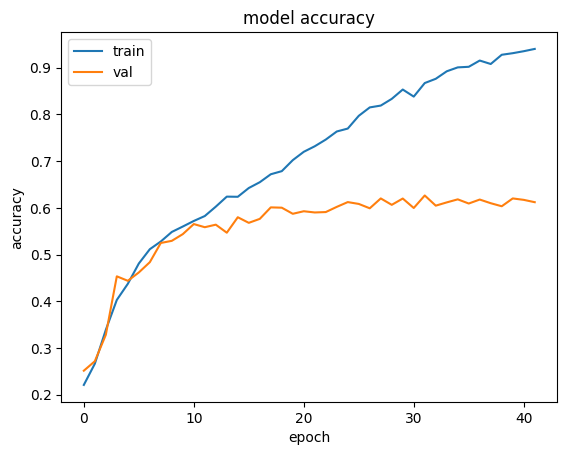

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**These are Best Training Phase-I weights, they are provided in the Weights Folder**

In [ ]:
model_conv.load_weights("/content/drive/MyDrive/emotionweights/CNN/model_weights_epoch_40.hdf5")

## Results reported Post Phase-I

In [ ]:
_, score= model_conv.evaluate(x_train_final, y_train_final)
print('Train score: {}'.format(score))

_, score= model_conv.evaluate(x_val, y_val)
print('Validation score: {}'.format(score))

_, score= model_conv.evaluate(x_test, y_test)
print('Test score: {}'.format(score))

575/575 [==============================] - 192s 332ms/step - loss: 0.0530 - accuracy: 0.9832
Train score: 0.9832362532615662
144/144 [==============================] - 44s 308ms/step - loss: 2.1445 - accuracy: 0.6202
Validation score: 0.6201567053794861
180/180 [==============================] - 55s 308ms/step - loss: 2.0743 - accuracy: 0.6289
Test score: 0.6288749575614929


## Collecting And Training Hard Samples for 20 epochs

In [ ]:

hard_images = []
hard_labels = []

predictions = model_conv.predict(x_val)
for i, v in enumerate(predictions):
    y_predict = np.argmax(v)
    y_real = y_val[i]
    if y_predict != y_real:

        image = x_val[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = np.array(hard_images)
y_hard = np.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

144/144 [==============================] - 9s 10ms/step
(1745, 48, 48)
(1745,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

history = model_conv.fit(x_hard,
                        y_hard,
                        batch_size=64,
                        epochs=20,
                        )

Epoch 1/20
28/28 [==============================] - 12s 79ms/step - loss: 2.7470 - accuracy: 0.1845
Epoch 2/20
28/28 [==============================] - 1s 52ms/step - loss: 1.7226 - accuracy: 0.2648
Epoch 3/20
28/28 [==============================] - 1s 51ms/step - loss: 1.6334 - accuracy: 0.3037
Epoch 4/20
28/28 [==============================] - 1s 51ms/step - loss: 1.5844 - accuracy: 0.3112
Epoch 5/20
28/28 [==============================] - 1s 49ms/step - loss: 1.5064 - accuracy: 0.3438
Epoch 6/20
28/28 [==============================] - 1s 49ms/step - loss: 1.4222 - accuracy: 0.3903
Epoch 7/20
28/28 [==============================] - 1s 49ms/step - loss: 1.3390 - accuracy: 0.4269
Epoch 8/20
28/28 [==============================] - 1s 50ms/step - loss: 1.2825 - accuracy: 0.4504
Epoch 9/20
28/28 [==============================] - 1s 49ms/step - loss: 1.1390 - accuracy: 0.5106
Epoch 10/20
28/28 [==============================] - 1s 50ms/step - loss: 1.0424 - accuracy: 0.5713
Epoch 11

## Training Phase-II

In [ ]:
x_train_final=np.reshape(x_train_final, (18373,48,48,1))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train_final,
                           y_train_final,
                           batch_size=64)

history = model_conv.fit(flow,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
288/288 [==============================] - 20s 65ms/step - loss: 1.2378 - accuracy: 0.5640 - val_loss: 0.8205 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 2/100
288/288 [==============================] - 18s 62ms/step - loss: 1.0827 - accuracy: 0.6127 - val_loss: 0.8447 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 3/100
288/288 [==============================] - 21s 73ms/step - loss: 1.0467 - accuracy: 0.6243 - val_loss: 0.8036 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 4/100
288/288 [==============================] - 20s 68ms/step - loss: 1.0258 - accuracy: 0.6369 - val_loss: 0.8397 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 5/100
288/288 [==============================] - 18s 61ms/step - loss: 1.0055 - accuracy: 0.6421 - val_loss: 0.8605 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 6/100
288/288 [==============================] - 18s 61ms/step - loss: 0.9910 - accuracy: 0.6457 - val_loss: 0.9078 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 7/100
288/288 [==============================]

**These are Best Training Phase-II weights, they are provided in the Weights Folder**

In [ ]:
model_conv.save_weights("/content/drive/MyDrive/emotionweights/CNN/after_data_play.hdf5")

In [ ]:
model_conv.load_weights("/content/drive/MyDrive/emotionweights/CNN/after_data_play.hdf5")

##Results Reported Post Phase-II

In [ ]:
_, score= model_conv.evaluate(x_train_final, y_train_final)
print('Train score: {}'.format(score))

_, score= model_conv.evaluate(x_val, y_val)
print('Validation score: {}'.format(score))

_, score= model_conv.evaluate(x_test, y_test)
print('Test score: {}'.format(score))

575/575 [==============================] - 177s 308ms/step - loss: 0.5727 - accuracy: 0.8042
Train score: 0.8042235970497131
144/144 [==============================] - 46s 317ms/step - loss: 0.8989 - accuracy: 0.6652
Validation score: 0.6652154922485352
180/180 [==============================] - 66s 364ms/step - loss: 0.9814 - accuracy: 0.6472
Test score: 0.6471612453460693


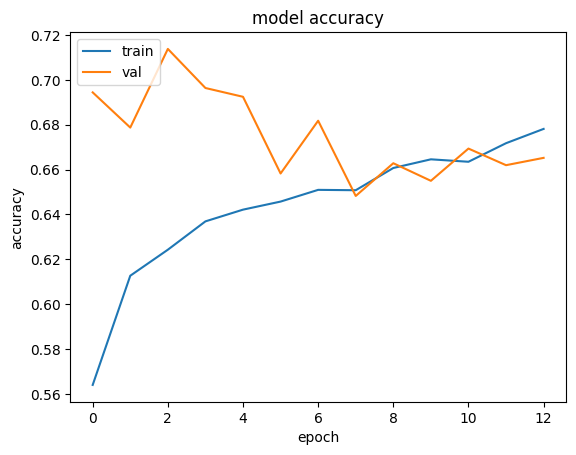

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Predictions And Feature Map Visualization

180/180 [==============================] - 59s 319ms/step


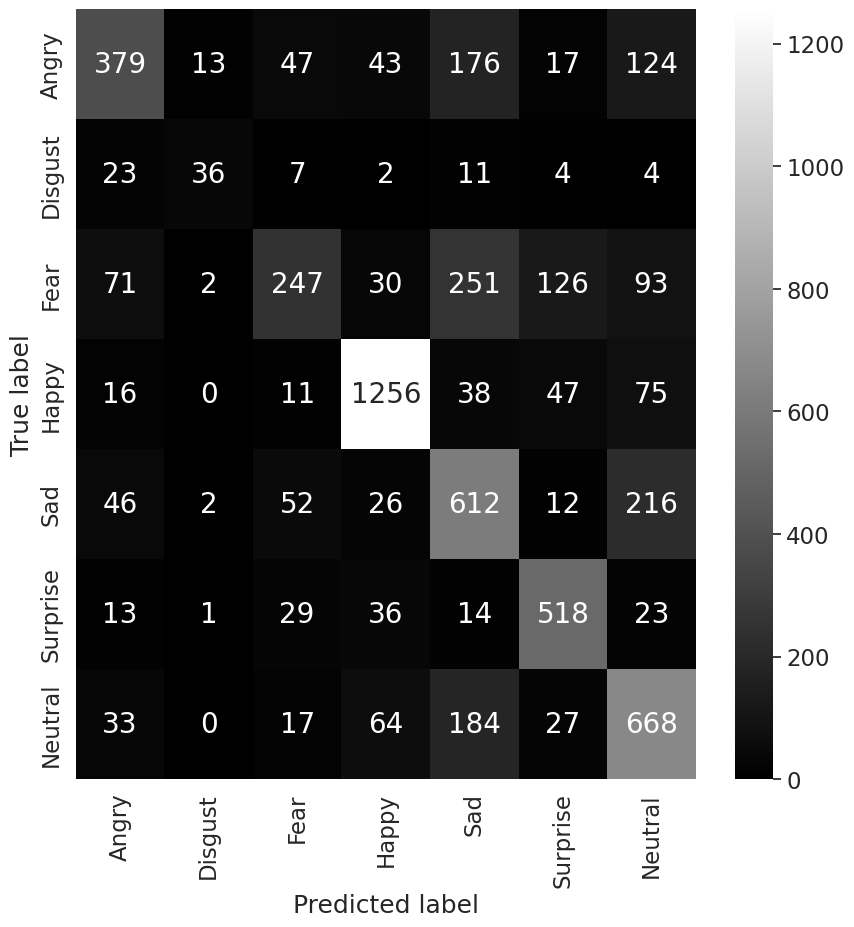

In [ ]:

y_true = y_test
y_pred=[]
predictions = model_conv.predict(x_test)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise','Neutral']

for i, v in enumerate(predictions):
    y_pred.append(np.argmax(v))

cm = confusion_matrix(y_true, y_pred)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, linewidths=0, square=False,
                 cmap='gray', yticklabels=emotion_labels,
                 xticklabels=emotion_labels, vmin=0, vmax=np.max(cm),
                 fmt="d",
                 annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

In [ ]:
input_image=np.reshape(x_train_final[100],(1,48,48,1))

1/1 [==============================] - 0s 63ms/step


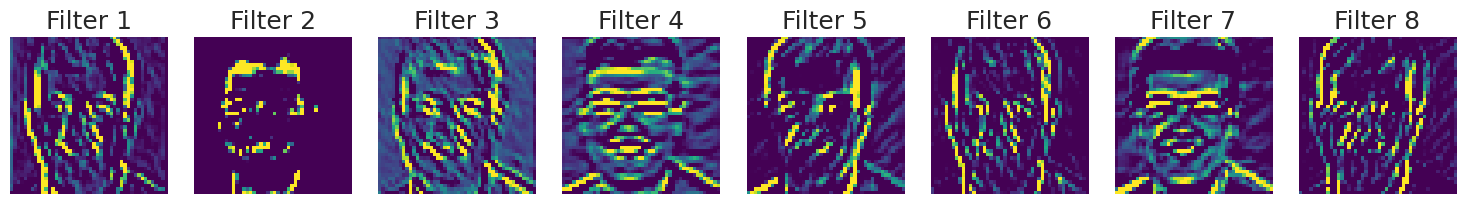

In [ ]:
layer_to_visualize = model_conv.layers[2]
feature_map_model = Model(inputs=model_conv.input, outputs=layer_to_visualize.output)
feature_map = feature_map_model.predict(input_image)

num_features_to_visualize = 8
plt.figure(figsize=(15, 5))

for i in range(num_features_to_visualize):

    feature_image = feature_map[0, :, :, i]
    feature_image -= feature_image.mean()
    feature_image /= feature_image.std()
    feature_image *= 64
    feature_image += 128
    feature_image = np.clip(feature_image, 0, 255).astype('uint8')

    ax = plt.subplot(1, num_features_to_visualize, i + 1)
    plt.imshow(feature_image, cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 351ms/step


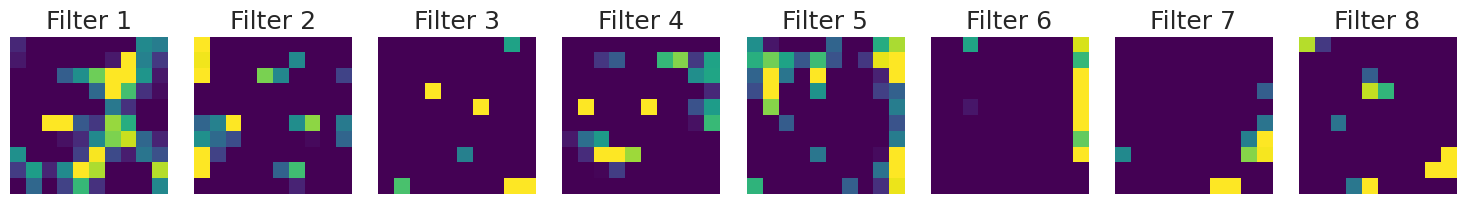

In [ ]:
layer_to_visualize = model_conv.layers[12]
feature_map_model = Model(inputs=model_conv.input, outputs=layer_to_visualize.output)
feature_map = feature_map_model.predict(input_image)

num_features_to_visualize = 8
plt.figure(figsize=(15, 5))

for i in range(num_features_to_visualize):

    feature_image = feature_map[0, :, :, i]
    feature_image -= feature_image.mean()
    feature_image /= feature_image.std()
    feature_image *= 64
    feature_image += 128
    feature_image = np.clip(feature_image, 0, 255).astype('uint8')

    ax = plt.subplot(1, num_features_to_visualize, i + 1)
    plt.imshow(feature_image, cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.tight_layout()
plt.show()


#Vision Transformer (ViT)

In [ ]:
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.reshape = layers.Reshape((4, 4))

    def call(self, x):

        batch_size = tf.shape(x)[0]
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, 4, 4, 1],
            strides=[1, 4, 4, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, 4 * 4 * 1])


        x = self.projection(patches)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = x + self.position_embedding(positions)
        return x


class TransformerBlock(layers.Layer):
    def __init__(self, projection_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.mlp = tf.keras.Sequential(
            [
                layers.Dense(units=projection_dim * 2, activation=tf.nn.gelu),
                layers.Dense(units=projection_dim),
            ]
        )

    def call(self, x):

        attn_output = self.attention(x, x)
        x = self.norm1(x + attn_output)

        mlp_output = self.mlp(x)
        return self.norm2(x + mlp_output)

def create_vit_classifier(input_shape, num_classes, num_patches, projection_dim, num_heads, transformer_layers):
    inputs = layers.Input(shape=input_shape)
    x = PatchEmbedding(num_patches=num_patches, projection_dim=projection_dim)(inputs)

    for _ in range(transformer_layers):
        x = TransformerBlock(projection_dim, num_heads)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


input_shape = (48, 48, 1)
num_classes = 7
num_patches = (48 // 4) * (48 // 4)
projection_dim = 16
num_heads = 4
transformer_layers = 4

model = create_vit_classifier(input_shape, num_classes, num_patches, projection_dim, num_heads, transformer_layers)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 patch_embedding (PatchEmbe  (None, 144, 16)           2576      
 dding)                                                          
                                                                 
 transformer_block (Transfo  (None, 144, 16)           5440      
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 144, 16)           5440      
 formerBlock)                                                    
                                                                 
 transformer_block_2 (Trans  (None, 144, 16)           5440      
 formerBlock)                                                

In [ ]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## Training stats of different Configurations which did not work

In [ ]:
#head=4 , project=64, patch=4
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/emotionweights/model_weights_epoch_{epoch:02d}.hdf5',  # File name format
    save_weights_only=True,                   # Save only the weights
    period=10)
history = model.fit(x_train_final,
                        y_train_final,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate,model_checkpoint])

Epoch 1/100
288/288 [==============================] - 23s 38ms/step - loss: 1.8961 - accuracy: 0.2123 - val_loss: 1.7932 - val_accuracy: 0.2560 - lr: 0.0010
Epoch 2/100
288/288 [==============================] - 11s 38ms/step - loss: 1.8008 - accuracy: 0.2498 - val_loss: 1.7466 - val_accuracy: 0.2775 - lr: 0.0010
Epoch 3/100
288/288 [==============================] - 11s 37ms/step - loss: 1.7549 - accuracy: 0.2779 - val_loss: 1.7353 - val_accuracy: 0.3024 - lr: 0.0010
Epoch 4/100
288/288 [==============================] - 10s 36ms/step - loss: 1.7155 - accuracy: 0.3027 - val_loss: 1.6803 - val_accuracy: 0.3224 - lr: 0.0010
Epoch 5/100
288/288 [==============================] - 11s 38ms/step - loss: 1.6886 - accuracy: 0.3225 - val_loss: 1.6434 - val_accuracy: 0.3357 - lr: 0.0010
Epoch 6/100
288/288 [==============================] - 10s 36ms/step - loss: 1.6498 - accuracy: 0.3504 - val_loss: 1.6320 - val_accuracy: 0.3476 - lr: 0.0010
Epoch 7/100
288/288 [==============================]

**Training Continued in the Cell below and showed signs of excessive over-ftting, therefore the configuration of projection-64 was not adopted as the final configuration**

In [ ]:
#Multi head=4 , projection=64, patch=4
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/emotionweights/model_weights_epoch_{epoch:02d}.hdf5',
    save_weights_only=True,
    period=10)
history = model.fit(x_train_final,
                        y_train_final,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate,model_checkpoint])

Epoch 1/100
288/288 [==============================] - 11s 37ms/step - loss: 1.2866 - accuracy: 0.5046 - val_loss: 1.6473 - val_accuracy: 0.3942 - lr: 8.1000e-04
Epoch 2/100
288/288 [==============================] - 10s 34ms/step - loss: 1.2605 - accuracy: 0.5199 - val_loss: 1.6080 - val_accuracy: 0.3875 - lr: 8.1000e-04
Epoch 3/100
288/288 [==============================] - 11s 37ms/step - loss: 1.2540 - accuracy: 0.5171 - val_loss: 1.6606 - val_accuracy: 0.3903 - lr: 8.1000e-04
Epoch 4/100
288/288 [==============================] - 11s 37ms/step - loss: 1.2334 - accuracy: 0.5244 - val_loss: 1.6902 - val_accuracy: 0.3746 - lr: 8.1000e-04
Epoch 5/100
288/288 [==============================] - 9s 33ms/step - loss: 1.2235 - accuracy: 0.5271 - val_loss: 1.7008 - val_accuracy: 0.3835 - lr: 8.1000e-04
Epoch 6/100
288/288 [==============================] - 10s 36ms/step - loss: 1.2087 - accuracy: 0.5311 - val_loss: 1.7067 - val_accuracy: 0.3811 - lr: 8.1000e-04
Epoch 7/100
288/288 [========

**Training with different configuration which also was not adopted**

In [ ]:
#head=4 , projection=32, patch=4
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/emotionweights/model_weights_epoch_{epoch:02d}.hdf5',  # File name format
    save_weights_only=True,
    period=10)
history = model.fit(x_train_final,
                        y_train_final,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
288/288 [==============================] - 17s 32ms/step - loss: 1.9517 - accuracy: 0.2029 - val_loss: 1.8012 - val_accuracy: 0.2521 - lr: 0.0010
Epoch 2/100
288/288 [==============================] - 6s 22ms/step - loss: 1.8204 - accuracy: 0.2364 - val_loss: 1.7693 - val_accuracy: 0.2712 - lr: 0.0010
Epoch 3/100
288/288 [==============================] - 9s 30ms/step - loss: 1.7734 - accuracy: 0.2660 - val_loss: 1.7303 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 4/100
288/288 [==============================] - 7s 23ms/step - loss: 1.7327 - accuracy: 0.2977 - val_loss: 1.6963 - val_accuracy: 0.3191 - lr: 0.0010
Epoch 5/100
288/288 [==============================] - 8s 26ms/step - loss: 1.7005 - accuracy: 0.3216 - val_loss: 1.6528 - val_accuracy: 0.3352 - lr: 0.0010
Epoch 6/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6678 - accuracy: 0.3379 - val_loss: 1.6453 - val_accuracy: 0.3489 - lr: 0.0010
Epoch 7/100
288/288 [==============================] - 8s

KeyboardInterrupt: ignored

## Training Phase-I

In [ ]:
#head=4 , project=16, patch=4
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/emotionweights/model_weights_epoch_{epoch:02d}.hdf5',  # File name format
    save_weights_only=True,
    period=10)
history = model.fit(x_train_final,
                        y_train_final,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
288/288 [==============================] - 38s 39ms/step - loss: 1.9324 - accuracy: 0.2042 - val_loss: 1.8055 - val_accuracy: 0.2560 - lr: 0.0010
Epoch 2/100
288/288 [==============================] - 9s 31ms/step - loss: 1.8274 - accuracy: 0.2406 - val_loss: 1.7853 - val_accuracy: 0.2556 - lr: 0.0010
Epoch 3/100
288/288 [==============================] - 10s 35ms/step - loss: 1.8084 - accuracy: 0.2484 - val_loss: 1.7769 - val_accuracy: 0.2636 - lr: 0.0010
Epoch 4/100
288/288 [==============================] - 10s 33ms/step - loss: 1.7811 - accuracy: 0.2686 - val_loss: 1.7495 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 5/100
288/288 [==============================] - 9s 31ms/step - loss: 1.7476 - accuracy: 0.2955 - val_loss: 1.6994 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 6/100
288/288 [==============================] - 10s 34ms/step - loss: 1.7128 - accuracy: 0.3192 - val_loss: 1.6706 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 7/100
288/288 [==============================] -

**Training continued below**

In [ ]:
save1=history.history['accuracy']
save2=history.history['val_accuracy']
np.save("/content/save1.npy",save1)
np.save("/content/save2.npy",save2)

In [ ]:
#head=4 , project=16, patch=4
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/emotionweights/model_weights_epoch_{epoch:02d}.hdf5',  # File name format
    save_weights_only=True,
    period=10)
history = model.fit(x_train_final,
                        y_train_final,
                        batch_size=64,
                        epochs=20,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/20
288/288 [==============================] - 14s 47ms/step - loss: 1.3952 - accuracy: 0.4649 - val_loss: 1.5776 - val_accuracy: 0.3918 - lr: 6.5610e-04
Epoch 2/20
288/288 [==============================] - 10s 33ms/step - loss: 1.3862 - accuracy: 0.4644 - val_loss: 1.5804 - val_accuracy: 0.4036 - lr: 6.5610e-04
Epoch 3/20
288/288 [==============================] - 9s 32ms/step - loss: 1.3782 - accuracy: 0.4666 - val_loss: 1.5744 - val_accuracy: 0.4023 - lr: 6.5610e-04
Epoch 4/20
288/288 [==============================] - 10s 35ms/step - loss: 1.3723 - accuracy: 0.4706 - val_loss: 1.5766 - val_accuracy: 0.4073 - lr: 6.5610e-04
Epoch 5/20
288/288 [==============================] - 10s 34ms/step - loss: 1.3694 - accuracy: 0.4686 - val_loss: 1.5908 - val_accuracy: 0.3979 - lr: 6.5610e-04
Epoch 6/20
288/288 [==============================] - 10s 36ms/step - loss: 1.3567 - accuracy: 0.4752 - val_loss: 1.5793 - val_accuracy: 0.4097 - lr: 6.5610e-04
Epoch 7/20
288/288 [===============

##Training Curve

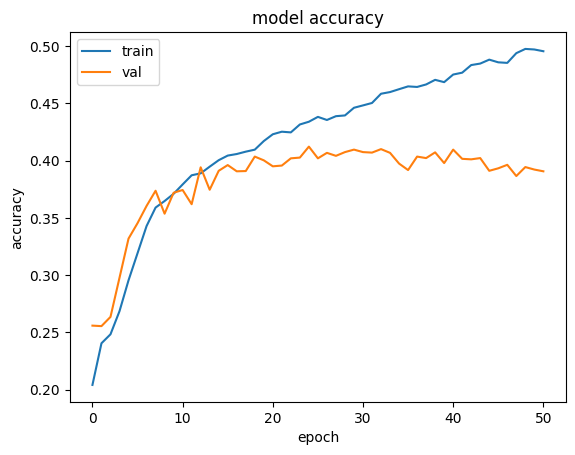

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(save1+history.history['accuracy'])
plt.plot(save2+history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**These are Best Training Phase-I weights, they are provided in the Weights Folder**

In [ ]:
model.save('/content/drive/MyDrive/emotionweights/train_50_val_40.keras')

In [ ]:
custom_objects = {"PatchEmbedding": PatchEmbedding,"TransformerBlock": TransformerBlock}
model = tf.keras.models.load_model("/content/drive/MyDrive/emotionweights/train_50_val_40.keras", custom_objects=custom_objects)

## Results reported Post Phase-I

In [ ]:
_, score= model.evaluate(x_train_final, y_train_final)
print('Train score: {}'.format(score))

_, score= model.evaluate(x_val, y_val)
print('Validation score: {}'.format(score))

_, score= model.evaluate(x_test, y_test)
print('Test score: {}'.format(score))

575/575 [==============================] - 68s 116ms/step - loss: 1.2417 - accuracy: 0.5202
Train score: 0.5202198624610901
144/144 [==============================] - 15s 106ms/step - loss: 1.6457 - accuracy: 0.3907
Validation score: 0.39072704315185547
180/180 [==============================] - 20s 112ms/step - loss: 1.6193 - accuracy: 0.3962
Test score: 0.3962033987045288


## Collecting and Training Hard Samples for 20 epochs

In [ ]:
hard_images = []
hard_labels = []

predictions = model.predict(x_val)
for i, v in enumerate(predictions):
    y_predict = np.argmax(v)
    y_real = y_val[i]
    if y_predict != y_real:
        image = x_val[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_train_final=np.reshape(x_train_final, (18373,48,48))

predictions = model.predict(x_train_final)
for i, v in enumerate(predictions):
    y_predict = np.argmax(v)
    y_real = y_train_final[i]
    if y_predict != y_real:
        image = x_train_final[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = np.array(hard_images)
y_hard = np.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

575/575 [==============================] - 6s 11ms/step
(11614, 48, 48)
(11614,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

history = model.fit(x_hard,
                        y_hard,
                        batch_size=64,
                        epochs=20,
                        )

Epoch 1/20
182/182 [==============================] - 14s 30ms/step - loss: 1.8043 - accuracy: 0.2140
Epoch 2/20
182/182 [==============================] - 6s 30ms/step - loss: 1.7658 - accuracy: 0.2465
Epoch 3/20
182/182 [==============================] - 5s 26ms/step - loss: 1.7546 - accuracy: 0.2579
Epoch 4/20
182/182 [==============================] - 5s 30ms/step - loss: 1.7441 - accuracy: 0.2723
Epoch 5/20
182/182 [==============================] - 6s 32ms/step - loss: 1.7363 - accuracy: 0.2712
Epoch 6/20
182/182 [==============================] - 5s 27ms/step - loss: 1.7249 - accuracy: 0.2784
Epoch 7/20
182/182 [==============================] - 7s 36ms/step - loss: 1.7210 - accuracy: 0.2847
Epoch 8/20
182/182 [==============================] - 8s 42ms/step - loss: 1.7091 - accuracy: 0.2909
Epoch 9/20
182/182 [==============================] - 5s 27ms/step - loss: 1.7014 - accuracy: 0.2970
Epoch 10/20
182/182 [==============================] - 6s 31ms/step - loss: 1.6929 - accur

In [ ]:
x_train_final=np.reshape(x_train_final, (18373,48,48,1))

##Training Phase-II

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train_final,
                           y_train_final,
                           batch_size=64)

history = model.fit(flow,
                        epochs=100,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
288/288 [==============================] - 37s 61ms/step - loss: 1.7228 - accuracy: 0.2998 - val_loss: 1.5794 - val_accuracy: 0.3781 - lr: 5.3144e-04
Epoch 2/100
288/288 [==============================] - 18s 63ms/step - loss: 1.6874 - accuracy: 0.3248 - val_loss: 1.5517 - val_accuracy: 0.3925 - lr: 5.3144e-04
Epoch 3/100
288/288 [==============================] - 19s 67ms/step - loss: 1.6715 - accuracy: 0.3343 - val_loss: 1.5398 - val_accuracy: 0.4010 - lr: 5.3144e-04
Epoch 4/100
288/288 [==============================] - 17s 60ms/step - loss: 1.6667 - accuracy: 0.3380 - val_loss: 1.5228 - val_accuracy: 0.4027 - lr: 5.3144e-04
Epoch 5/100
288/288 [==============================] - 18s 61ms/step - loss: 1.6534 - accuracy: 0.3470 - val_loss: 1.5313 - val_accuracy: 0.4164 - lr: 5.3144e-04
Epoch 6/100
288/288 [==============================] - 17s 60ms/step - loss: 1.6469 - accuracy: 0.3535 - val_loss: 1.5196 - val_accuracy: 0.4112 - lr: 5.3144e-04
Epoch 7/100
288/288 [=======

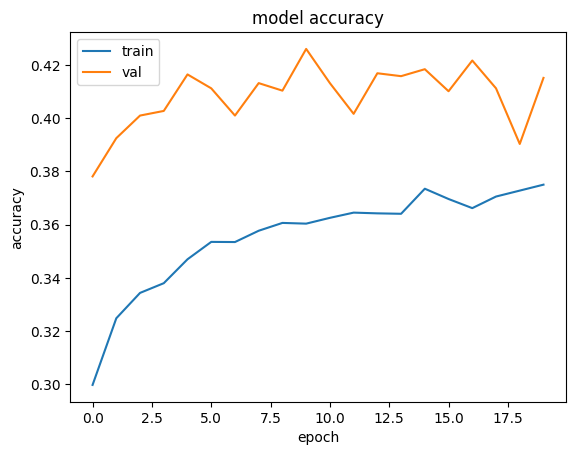

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**These are Best Training Phase-II weights, they are provided in the Weights Folder**

In [ ]:
model.save_weights("/content/drive/MyDrive/emotionweights/after_data_play2.hdf5")

In [ ]:
model.load_weights("/content/drive/MyDrive/emotionweights/after_data_play2.hdf5")

##Results Reported Post Phase-II

In [ ]:
_, score= model.evaluate(x_train_final, y_train_final)
print('Train score: {}'.format(score))

_, score= model.evaluate(x_val, y_val)
print('Validation score: {}'.format(score))

_, score= model.evaluate(x_test, y_test)
print('Test score: {}'.format(score))

575/575 [==============================] - 62s 107ms/step - loss: 1.4641 - accuracy: 0.4295
Train score: 0.4295433461666107
144/144 [==============================] - 15s 106ms/step - loss: 1.5053 - accuracy: 0.4151
Validation score: 0.4151066541671753
180/180 [==============================] - 19s 108ms/step - loss: 1.5021 - accuracy: 0.4187
Test score: 0.4186694622039795


##Prediction and Feature-activation Visualization

180/180 [==============================] - 20s 108ms/step


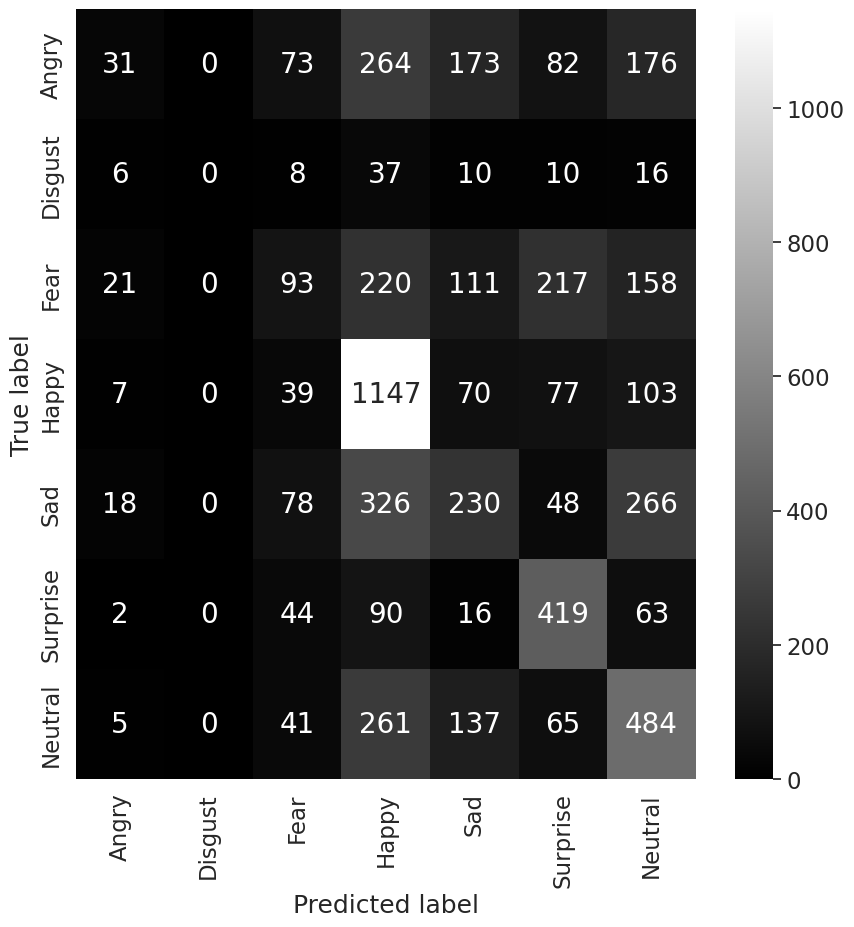

In [ ]:

y_true = y_test
y_pred=[]
predictions = model.predict(x_test)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise','Neutral']

for i, v in enumerate(predictions):
    y_pred.append(np.argmax(v))

cm = confusion_matrix(y_true, y_pred)

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(cm, annot=True, linewidths=0, square=False,
                 cmap='gray', yticklabels=emotion_labels,
                 xticklabels=emotion_labels, vmin=0, vmax=np.max(cm),
                 fmt="d",
                 annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')
plt.show()

1/1 [==============================] - 0s 116ms/step


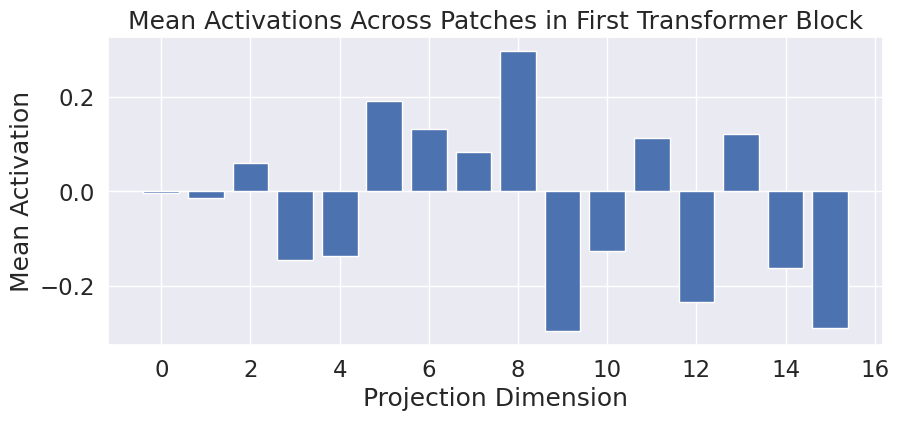

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
input_image=np.reshape(x_train_final[1],(1,48,48,1))

layer_outputs = model.layers[1].output
intermediate_model = Model(inputs=model.input, outputs=layer_outputs)

activations = intermediate_model.predict(input_image)

mean_activations = np.mean(activations, axis=1).squeeze()
plt.figure(figsize=(10, 4))
plt.bar(range(projection_dim), mean_activations)
plt.xlabel('Projection Dimension')
plt.ylabel('Mean Activation')
plt.title('Mean Activations Across Patches in First Transformer Block')
plt.show()

1/1 [==============================] - 1s 882ms/step


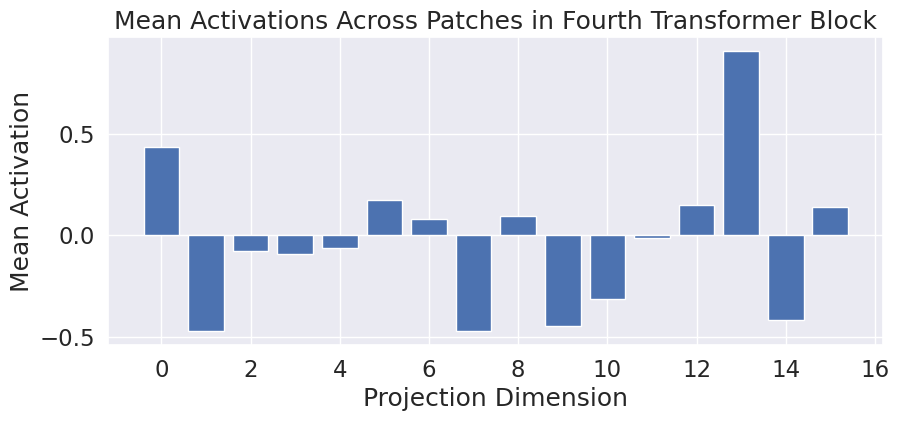

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

layer_outputs = model.layers[5].output
intermediate_model = Model(inputs=model.input, outputs=layer_outputs)
activations = intermediate_model.predict(input_image)

mean_activations = np.mean(activations, axis=1).squeeze()
plt.figure(figsize=(10, 4))
plt.bar(range(projection_dim), mean_activations)
plt.xlabel('Projection Dimension')
plt.ylabel('Mean Activation')
plt.title('Mean Activations Across Patches in Fourth Transformer Block')
plt.show()